## Здравствуйте, меня зовут *Николай Королев*, вот моё Задание №1 по курсу ПСАД-2020!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'


RANDOM_SEED = 45135
np.random.seed(RANDOM_SEED)

In [2]:
from scipy.stats import linregress

def draw_linear(x, y, x_name='', y_name=''):
    "Scatter x-y points and draw a LR line."
    slope, intercept, r, _, _ = linregress(x, y)
    x_lims = np.array([x.min() - 1, x.max() + 1])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot(x, y, 'g+', label='Objects')
    plt.plot(x_lims, intercept + slope * x_lims, 'r--', label=r"LR line with $\rho \approx {:.3f}$".format(r))
    plt.legend()
    plt.show()

In [3]:
from sklearn.metrics import confusion_matrix

def draw_cm(x_bin, y_bin, x_name='', y_name=''):
    "Draw a confusion matrix for binary 1-D arrays x_bin and y_bin."
    cm = confusion_matrix(x_bin, y_bin)
    plt.matshow(cm)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.colorbar()
    plt.grid(False)
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            text = plt.text(j, i, cm[i, j], ha="center", va="center", bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.show()

In [4]:
from itertools import combinations
from collections import defaultdict

def apply_pair_statistics(S, pair_statistics, statistics_names):
    """Apply pair statistics to each pair in a dataset S 
    and return a DataFrame containing the results.
    
    Parameters
    ----------
    S: array of shape (N, D)
        A dataset numpy array.
    pair_statistics: list of callables
        A list of statistics -- functions requiring two array arguments (x and y) 
        and returning a number (statistic's value)
    statistics_names: list of strings
        A list of statistics names.
    """
    res = defaultdict(list)

    for i, j in combinations(range(S.shape[1]), 2):
        x_name, y_name = f'X{i+1}', f'X{j+1}'
        x, y = S.T[i], S.T[j]
        res["Pair"].append(x_name + ' - ' + y_name)
        for statistic, name in zip(pair_statistics, statistics_names):
            res[name].append(statistic(x, y))

    res = pd.DataFrame(res)
    return res

## Итак...

Пусть задана обучающая выборка $\widetilde{S}$, включающая значения переменных $X_1, \dots, X_4$.

In [5]:
S = np.load('data', allow_pickle=True)

### Задача 1  

Вычислите для каждой пары переменных коэффициент корреляции Пирсона.

In [6]:
def pearson(x, y):
    "Calculate a Pearson correlation coefficient given 1-D data arrays x and y."
    return ((x * y).mean() - x.mean() * y.mean()) / np.std(x) / np.std(y)

res_pearson = apply_pair_statistics(S, [pearson], ['Pearson'])
res_pearson

,Pair,Pearson
0,X1 - X2,0.717535
1,X1 - X3,0.214944
2,X1 - X4,0.179368
3,X2 - X3,0.388575
4,X2 - X4,0.352562
5,X3 - X4,0.873796


Сопоставьте каждой из переменных  $X_1,\dots,X_4$  соответствующую порядковую переменную.

In [7]:
def rank(x):
    "Assign ranks to data and return the resulting ranking array with averaging ranks of tied values."
    argsorted = x.argsort()
    x_sorted = np.empty_like(x)
    x_sorted[:] = x[argsorted]
    ranks = np.cumsum(np.r_[True, x_sorted[1:] != x_sorted[:-1]])
    
    inv_argsort = np.empty_like(argsorted)
    inv_argsort[argsorted] = np.arange(len(x))
    
    mask = np.r_[True, ranks[1:] != ranks[:-1]]
    all_ranks = np.arange(len(x)) + 1
    mapping_array = all_ranks[mask].astype(float)
    min_ranks_mask = np.r_[mask[:-1] & ~mask[1:], False]
    min_ranks = all_ranks[min_ranks_mask]
    max_ranks = all_ranks[np.r_[~mask[:-1] & mask[1:], ~mask[-1]]]

    corrected_ranks = (min_ranks + max_ranks) / 2
    mapping_array = mapping_array.astype(corrected_ranks.dtype)
    mapping_array[ranks[min_ranks_mask] - 1] = (min_ranks + max_ranks) / 2
    
    ranks = mapping_array[ranks - 1][inv_argsort]
    return ranks

S_r = np.array([rank(x) for x in S.T]).T

Вычислите для каждой из пар переменных коэффициенты корреляции Спирмена и Кендалла ($\tau$-коэффициент).

In [8]:
def spearman(x_r, y_r):
    "Calculate a Spearman correlation coefficient given 1-D ranking arrays x_r and y_r."
    return pearson(x_r, y_r)

def kendall(x_r, y_r):
    "Calculate a Kendall tau correlation coefficient given 1-D ranking arrays x_r and y_r."
    def create_sign_matrix(x):
        x_mask = x[np.newaxis, :] - x[:, np.newaxis]
        x_mask[x_mask < 0] = -1
        x_mask[x_mask > 0] = 1
        return x_mask
    
    x_sign = create_sign_matrix(x_r)
    y_sign = create_sign_matrix(y_r)
    sign_matrix = x_sign * y_sign
    total = np.abs(sign_matrix).sum()
    x_ties = ((x_sign == 0) & (y_sign != 0)).sum()
    y_ties = ((y_sign == 0) & (x_sign != 0)).sum()
    return sign_matrix.sum() / np.sqrt((total + x_ties) * (total + y_ties))

res_ranked = apply_pair_statistics(S_r, [spearman, kendall], ['Spearman', 'Kendall'])
res_ranked

,Pair,Spearman,Kendall
0,X1 - X2,0.999789,0.996545
1,X1 - X3,0.068620,0.050911
2,X1 - X4,0.047029,0.038293
3,X2 - X3,0.070098,0.052847
4,X2 - X4,0.048231,0.041470
5,X3 - X4,0.819520,0.650535


Посмотрите на общую таблицу результатов и на графики ниже, сделайте выводы. 

При желании можно построить свои графики / вывести дополнительные результаты.

In [9]:
res_final = pd.merge(res_pearson, res_ranked)
res_final

,Pair,Pearson,Spearman,Kendall
0,X1 - X2,0.717535,0.999789,0.996545
1,X1 - X3,0.214944,0.068620,0.050911
2,X1 - X4,0.179368,0.047029,0.038293
3,X2 - X3,0.388575,0.070098,0.052847
4,X2 - X4,0.352562,0.048231,0.041470
5,X3 - X4,0.873796,0.819520,0.650535


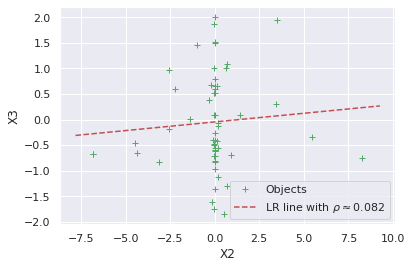

In [10]:
mask = S.T[1] < 30
draw_linear(S.T[1][mask], S.T[2][mask], f'X2', f'X3')

**Выводы:** На паре X1-X2 можно увидеть явную монотонную зависимость, которая не идеально отлавливается коэффициентом корреляции Пирсона, т.к. зависимость не линейная, но при этом великолепно находится при помощи коэффициента корреляции Спирмена и Кэндалла. На паре X2-X3 и X2-X4 можно увидеть неустойчивость коэффициента корреляции Пирсона к выбросам (он чрезвычайно высок), хотя в действительности никакой очевидной зависимости не наблюдается, что можно понять по коэффициентам корреляции Спирмена и Кэндалла. На паре X3-X4 прослеживается линейная зависимость, что соответствует тому, что все исследуемые коэффициенты корреляции достаточно высоки.

### Задача 2


Бинаризуйте выборку $\widetilde{S}$ по медиане.

In [11]:
S_bin = S <= np.median(S, axis=0)[np.newaxis, :]

Вычислите для каждой пары бинаризованных переменных коэффициенты близости Жаккарда и $\phi$.

In [12]:
def jaccard(x_bin, y_bin):
    "Compute the Jaccard coefficient given 1-D boolean arrays x_bin and y_bin."
    return (x_bin & y_bin).sum() / (x_bin | y_bin).sum()

def phi(x_bin, y_bin):
    "Compute the phi coefficient given 1-D boolean arrays x_bin and y_bin."
    a = (x_bin & y_bin).sum()
    b = (~x_bin & y_bin).sum()
    c = (x_bin & ~y_bin).sum()
    d = (~x_bin & ~y_bin).sum()
    return (a * d - b * c) / np.sqrt((a + b) * (c + d) * (b + d) * (a + c))

res_bin = apply_pair_statistics(S_bin, [jaccard, phi], ['Jaccard', 'Phi'])
res_bin

,Pair,Jaccard,Phi
0,X1 - X2,1.000000,1.000000
1,X1 - X3,0.318182,-0.052956
2,X1 - X4,0.380952,0.087438
3,X2 - X3,0.318182,-0.052956
4,X2 - X4,0.380952,0.087438
5,X3 - X4,0.757576,0.719212


Сделайте выводы по полученным результатам и приведённым ниже матрицам ошибок.

При желании можно построить свои графики / вывести дополнительные результаты.

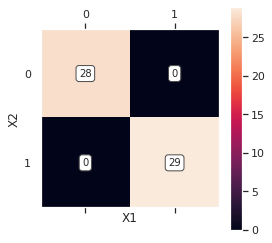

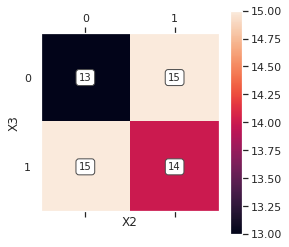

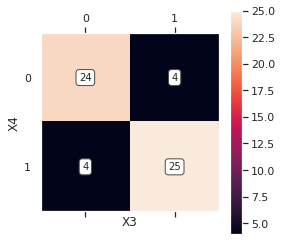

In [13]:
draw_cm(S_bin.T[0], S_bin.T[1], 'X1', 'X2')
draw_cm(S_bin.T[1], S_bin.T[2], 'X2', 'X3')
draw_cm(S_bin.T[2], S_bin.T[3], 'X3', 'X4')

**Выводы:** На паре X1-X2 виден случай идеального совпадения векторов из-за коэффициенты близости Жаккара и $\phi$ равны 1. Это соответствует результату из предыдущей задачи, т.к. данная пара переменных имеет монотонную зависимость, а бинаризация производилась по медиане. На паре X2-X3 видно, что вектора на самом деле отличаются примерно в половине позиций (данный случай вполне может соответствовать двум независимым случайным векторам), но при этом коэффициент близости Жаккара необоснованно высок, в отличие от $\phi$, который показывает меру близости около 0. Хотя в случае, если бы нули были не информативны, можно было бы смотреть на коэффициент близости Жаккара, т.к. в таком случае он показывает более адекватную оценку схожесть векторов. Вектора X3 и X4 схожи, при этом в них примерно равное количество единиц и нулей, поэтому коэффициенты близости Жаккара и $\phi$ достаточно высоки. По итогу, можно сделать вывод о том, что в случае наличия незначащих нулей лучше использовать коэффициент близости Жаккара, а в случае, если нули необходимо учитывать, лучше склоняться в сторону использования $\phi$. 

### Задача 3

#### Продолжительность жизни крыс

В исследовании принимало участие 195 крыс. 106 из них держали на строгой диете, оставшиеся 89 — на диете ad libitum. Имеющиеся данные: продолжительность жизни крыс в каждой из групп. Влияет ли диета на продолжительность жизни?

In [14]:
rats = pd.read_table("rats.txt", sep="\t")
rats.sample(5)

,lifespan,diet
97,1258,restricted
61,1076,restricted
7,390,restricted
104,1393,restricted
134,667,ad libitum


In [15]:
x1 = rats.loc[rats['diet'] == 'restricted']['lifespan']
x2 = rats.loc[rats['diet'] == 'ad libitum']['lifespan']

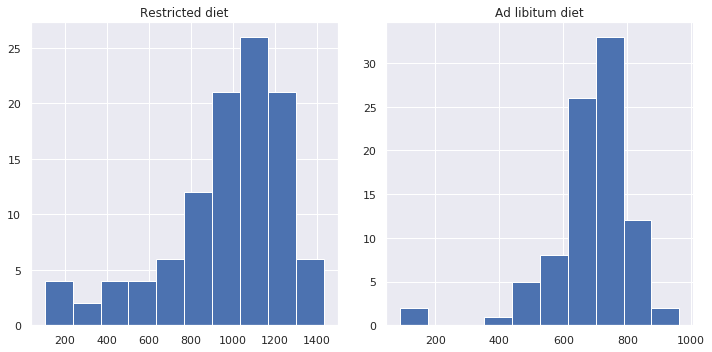

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Restricted diet')
plt.hist(x1)
plt.subplot(1, 2, 2)
plt.title('Ad libitum diet')
plt.hist(x2)
plt.tight_layout()
plt.show()

1. Нарисуйте один график с двумя boxplot на нем (для каждой из диет). Укажите на графике 95% доверительный интервал для каждой из медиан. В этом вам поможет функция boxplot(..., notch=TRUE), которой первым аргументом можно передать объект типа формула.

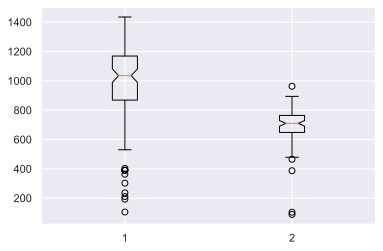

In [27]:
plt.boxplot([x1, x2], notch=True)
plt.show()

### Нормальность

2. Проверим нормальность двух выборок (для каждой из диет). Для этого нарисуйте qq-график и отметьте на нем прямую линию, соответствующую идеальным теоретическим квантилям нормального распределения. Похожи ли данные на нормальное распределение?

3. Попробуйте исключить крыс, проживших меньше 400 дней (например, можно предположить, что смерть раньше этого срока вызывается причинами, не связанными с диетой) и снова нарисовать qq-графики. Можно ли применять к этим данным критерии, основанные на предположении о нормальности?

Усечённые выборки можно считать практически нормальными.

### Сравнение средних

Проверьте нулевую гипотезу

$H_0$: продолжительность жизни крыс не меняется при ограничении диеты.

против следующих альтернатив:

$H_1$: крысы на строгой диете живут дольше.

$H_1$: средняя продолжительность жизни крыс меняется при ограничении диеты. 

Проверить правильность вычислений вы можете с помощью библиотечной функции `scipy.stats.ttest_ind`, которая реализует двусторонний критерий Стьюдента для двух независимых выборок.